# Travelling Santa (Kaggle)

https://www.kaggle.com/c/traveling-santa-2018-prime-paths

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time,sleep
import os
import itertools

### Let us first import the dataset and visualize the world we're dealing with!

In [2]:
cities = pd.read_csv('cities.csv')
cities.head()

,CityId,X,Y
0,0,316.836739,2202.340707
1,1,4377.405972,336.602082
2,2,3454.158198,2820.053011
3,3,4688.099298,2935.898056
4,4,1010.696952,3236.750989


In [3]:
maxCities = 1000

if maxCities:
    cities = cities.iloc[:maxCities, :]

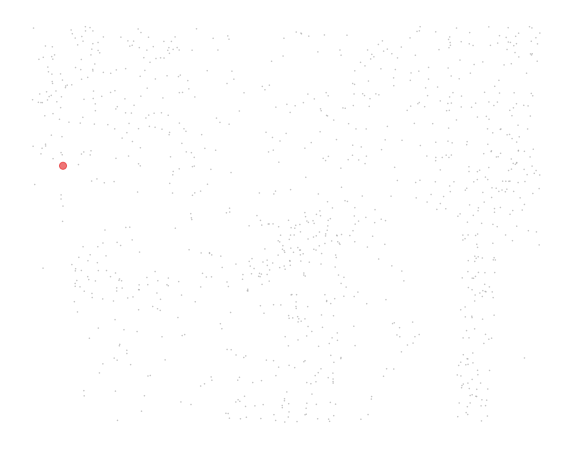

In [4]:
plt.rcParams['agg.path.chunksize'] = 10000
fig = plt.figure(figsize=(10,8))
plt.scatter(cities['X'],cities['Y'],marker = '.',c=(cities.CityId != 0).astype(int), cmap='Set1', alpha = 0.6, s = 200*(cities.CityId == 0).astype(int)+1)
plt.axis('off')
plt.show()

In [5]:
print(cities.shape)

(1000, 3)


<font color='blue'>The city coordinates make a reindeer pattern. The red point (Rudolf's Nose?) is the North Pole.</font>

### Some useful functions before actually moving on with the solutions:

In [6]:
def generate_primes(n):
    primes = [True] * (n + 1)
    primes[0] = primes[1] = False # 0 and 1 are not primes
    for i in range(2,int(n**0.5)):
        if primes[i]:
            j = 2
            while i * j <= n:
                primes[i*j] = False
                j += 1
    return primes

primes = generate_primes(max(cities.CityId))

def distance(df,CityId1,CityId2):
    return np.sqrt((df.X[CityId1]-df.X[CityId2])**2+(df.Y[CityId1]-df.Y[CityId2])**2)

def distanceCovered(path):
    prevCity = path[0]
    dist = 0
    steps = 1
    for city in path[1:]:
        dist += distance(cities,city,prevCity) * (1 + (steps % 10 == 0) * (not primes[int(prevCity)]) * 0.1)
        prevCity = city
        steps +=1
    return dist

### Naive Implementation

<font color='blue'>Visiting cities in ascending order of ```CityId```</font>

In [7]:
print("Naive implementation distance = {0:,}".format(distanceCovered(list(range(max(cities.CityId)))+[0])))

Naive implementation distance = 2,190,383.3998705917


The distance is a whopping 446 million!! Surely we can do better!!


### Nearest Neighbour
Next, we can try going to the closest city from each previous city.

In [8]:
def distVector(df,city,Nvisited):
    n = max(df.CityId)+1
    coords = np.array([df.X,df.Y])
    Ccoords = np.array([[df.X[city]]*coords.shape[1],[df.Y[city]]*coords.shape[1]])
    dists = np.sqrt(np.sum((coords - Ccoords)*Nvisited.astype(int),axis=0)**2)
    dists[dists == 0] = 9e245
    return dists

def NNRoute(df):
    n = max(df.CityId)+1
    route = np.zeros((n+1))
    print(route.size)
    Nvisited = np.array([True] * n)
    last_city = 0
    Nvisited[0] = False
    steps = 0
    while np.any(Nvisited):
        dists = distVector(df,last_city,Nvisited)
        next_city = np.argmin(dists)
        steps += 1
        if steps % 100 == 1:
            print(" "*100,end='\r')
            print("{0:3.2f}%\t[{1}{2}]\tsteps = {3}\t{4} visited".format(steps/n*100,"="*int(steps/(n-1)*40)," "*int(40-steps/(n-1)*40),steps,np.sum(np.logical_not(Nvisited))),end='\r')
        route[steps] = next_city
        last_city = next_city
        Nvisited[last_city] = False
    return route

start = time()
route = NNRoute(cities)
timeTaken = time() - start

1001


In [9]:
totaldist = distanceCovered(route)
print("Nearest Neighbour implementation distance = {0:,}\nTook {1} seconds.".format(totaldist,timeTaken))

Nearest Neighbour implementation distance = 1,223,930.1878671534
Took 0.7899937629699707 seconds.


<font color='blue'>Just by using a simple algorithm the distance has almost reduced by half!</font>

### What more?
Try making all 10th cities visited primes? But which prime? There aren't enough primes for all 10th cities to be prime, are there?

In [10]:
print("Ratio of primes to total no. of cities: ",np.sum(primes)/(max(cities.CityId)+1))

Ratio of primes to total no. of cities:  0.169


<font color=#00AAAA>Well, kind of... There's about 9% of primes... Seems this method might be worth a try! Choose the nearest prime? Seems logical! Let's try that now!</font>

In [11]:
def NNPrimesRoute(df):
    n = max(df.CityId)+1
    route = np.zeros((n+1))
    steps = 0
    print(route.size)
    visited = np.array([False] * n)
    last_city = 0
    visited[0] = True
    while np.any(np.logical_not(visited)):
        steps += 1
        dists = distVector(df,last_city,np.logical_not(visited))
        next_city = -1
        if (steps + 1) % 10 == 0:
            primes_dists = dists*(np.array(primes).astype(int))
            primes_dists[primes_dists == 0] = 9e245
            next_city = np.argmin(primes_dists)
        if (not (steps + 1) % 10 == 0) or visited[next_city]:
            next_city = np.argmin(dists)
        print(" "*100,end='\r')
        print("{0:3.2f}%\t[{1}{2}]\tsteps = {3}\t{4} visited".format(steps/n*100,"="*int(steps/(n-1)*40)," "*int(40-steps/(n-1)*40),steps,np.sum(visited)),end='\r')
        route[steps] = next_city
        last_city = next_city
        visited[last_city] = True
    return route

In [12]:
start = time()
route = NNPrimesRoute(cities)
timeTaken = time() - start

1001


In [13]:
totaldist = distanceCovered(route)
print("Nearest Neighbour with primes implementation distance = {0:,}\nTook {1} seconds.".format(totaldist,timeTaken))

Nearest Neighbour with primes implementation distance = 1,233,102.6940745802
Took 1.291996955871582 seconds.


<font color=#00AAFF>Well, not much...</font>

### Following nature's example!
Next we can try out genetic algorithms!

In [14]:
def initSeed(seed):
    np.random.seed(seed)

def createNewGene(cities):
    gene = np.array(cities.CityId.tolist()+[0])
    np.random.shuffle(gene[1:-1])
    return gene

def generatePopulation(df, n):
    population = [createNewGene(df) for i in range(n)]
    return population

def crossOver(bestpop, popSize, bestpopperc):
    if not len(bestpop) == int(popSize*bestpopperc):
        raise ValueError('Length of best population is not right.')
    newPop = bestpop.copy()
    for i in range(int(popSize-len(bestpop))):
        idx = np.random.randint(0, int(len(bestpop)), size=(2))
        parents = [bestpop[i] for i in idx]
        child = np.zeros((parents[0].size))
        r1 = np.random.randint(0, parents[0].size, size=(2))
        if r1[0] > r1[1]:
            r1 = [r1[1],r1[0]]
        child[r1[0]:r1[1]] = parents[0][r1[0]:r1[1]]
        r = 1
        for i in list(range(1,r1[0]))+list(range(r1[1],parents[0].size)):
            for j in range(r,parents[1].size):
                if parents[1][j] not in child:
                    child[i] = parents[1][j]
                    r = j + 1
                    break
        newPop = np.append(newPop,child.reshape((1,child.size)),0)
    return newPop

def mutate(pop, mutateProb = 0.05):
    for i in pop:
        p = np.random.rand()
        if p < mutateProb:
            np.random.shuffle(i[1:-1])

def geneticAlgortithm(df, popSize = 100, mutateProb = 0.05, bestPopPerc = 0.5, numGen = 100, useOld = True, oldNum = 0, seed = 123):
    %matplotlib notebook
    n = max(df.CityId) + 1
    pop = cache = top10Genes = None
    if not popSize % 2 == 0:
        raise ValueError("Population size must be even.")
    if os.path.exists('saves'):
        if not useOld:
            initSeed(seed)
            pop = np.array(generatePopulation(df, popSize))
        elif os.path.isfile("saves/genetic_pop_{0}_{1}.npy".format(popSize, oldNum)):
            pop = np.load("saves/genetic_pop_{0}_{1}.npy".format(popSize, oldNum), allow_pickle = True)
            print("Using old population.")
        else:
            raise FileNotFoundError()
        if not useOld:
            cache = {'scores':[],'bestGene':[],'genNo':[]}
        elif os.path.isfile("saves/genetic_cache_{0}_{1}.npy".format(popSize, oldNum)):
            cache = np.load("saves/genetic_cache_{0}_{1}.npy".format(popSize, oldNum), allow_pickle = True).item()
            print("Using old cache.")
        else:
            raise FileNotFoundError()
        if not useOld:
            top10Genes = {'genes':[0]*10,'score':[9e245]*10}
        elif os.path.isfile("saves/genetic_top10_{0}_{1}.npy".format(popSize,oldNum)):
            top10Genes = np.load("saves/genetic_top10_{0}_{1}.npy".format(popSize, oldNum), allow_pickle = True).item()
            print("Using old top.")
        else:
            raise FileNotFoundError()
    else:
        os.makedirs('saves')
        initSeed(seed)
        pop = np.array(generatePopulation(df, popSize))
        cache = {'scores':[],'bestGene':[],'genNo':[]}
        top10Genes = {'genes':[0]*10,'score':[9e245]*10}
    
    scores = np.zeros((popSize))
    
    fig = plt.figure(figsize = (8,6))
    ax = fig.add_subplot(111)
    plt.ion()
    fig.show()
    fig.canvas.draw()

    print('Starting algorithm.')
    for i in range(0 if (len(cache['genNo']) == 0) else cache['genNo'][-1],numGen):
        scores = np.apply_along_axis(distanceCovered,1,pop)
        idx = scores.argsort()
        bestpop = pop[idx][:int(popSize * bestPopPerc)]
        bestscores = scores[idx][:int(popSize * bestPopPerc)]
        if len(cache['genNo']) > 0:
            cache['genNo'].append(cache['genNo'][-1]+1)
        else:
            cache['genNo'].append(1)
        print('Best scores calculated. Generation {0}.'.format(cache['genNo'][-1]),end='\r')
        top10gene = pop[idx][:10]
        top10scores = scores[idx][:10]
        r = 0
        for i in range(min(9,top10scores.size-1),-1,-1):
            for j in range(r,10):
                if top10scores[i] <= top10Genes['score'][j]:
                    top10Genes['genes'][j] = top10gene[i]
                    top10Genes['score'][j] = top10scores[i]
                    r = j
                    break
        cache['bestGene'].append(np.array(pop)[idx == popSize-1])
        cache['scores'].append(scores[idx][0])
        ax.clear()
        ax.plot(cache['genNo'],cache['scores'])
        fig.canvas.draw()
        pop = crossOver(bestpop, popSize, bestPopPerc)
        mutate(pop, mutateProb)
        
        if cache['genNo'][-1] % 5 == 0:
            np.save("saves/genetic_pop_{0}_{1}".format(pop.shape[0], oldNum),pop)
            np.save("saves/genetic_top10_{0}_{1}".format(pop.shape[0], oldNum),top10Genes)
            np.save("saves/genetic_cache_{0}_{1}".format(pop.shape[0], oldNum),cache)
            print("Generation {} saved.                           ".format(cache['genNo'][-1]),end="\r")
    
    return cache, top10Genes, pop

<IPython.core.display.Javascript object>


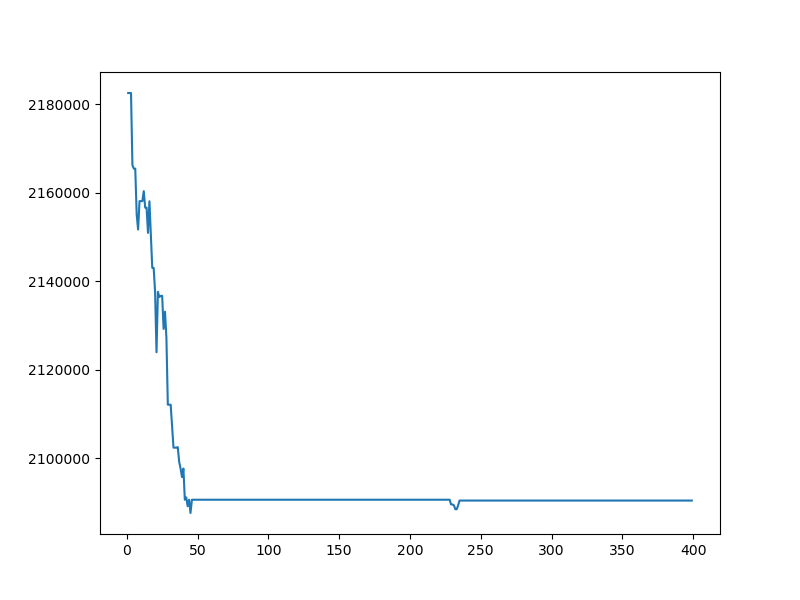

Starting algorithm.


KeyboardInterrupt: 

In [16]:
start = time()
cache, top10Genes, pop = geneticAlgortithm(cities, popSize = 20, numGen = 10000, mutateProb = 0.4, bestPopPerc = 0.4, useOld = False)
timeTaken = time() - start
print("Genetic Algorithm returned a best score of {0}.\nTook {1} seconds.".format(top10Genes['score'][0],timeTaken))

In [ ]:
class World():
    def __init__(self):
        self.coords = cities
        self.visited = np.zeros((self.coords.shape[0]))
        self.order = np.zeros((self.coords.shape[0]+1))
        self.steps = 1
    
    def step(self, action):
        if action not in np.logical_not(self.visited):
            return "Illegal"
        
        self.order[self.steps] = action
        self.steps += 1
        self.visited[action] = 1
        done = self.visited.all()
        return self.visited, done * distanceCovered(self.coords, self.order), done
    
    def reset(self):
        self.visited = np.zeros((self.coords.shape[0]))
        self.order = np.zeros((self.coords.shape[0]+1))
        self.steps = 1
        return self.visited
    
    def possibleActions(self):
        return np.argwhere(np.logical_not(self.visited)).flatten()

In [ ]:
def QLearning(env, gamma = 0.9, eps = 0.05, alpha = 0.1, nEpis = 10000):
    np.random.seed(123)
    
    P = {str(s):np.random.randint(cities.shape[0]) for s in list(np.array(seq) for seq in itertools.product([0,1], repeat=cities.shape[0]))}
    Q = {str(s):np.zeros(cities.shape[0]) for s in list(np.array(seq) for seq in itertools.product([0,1], repeat=cities.shape[0]))}
    
    for i in range(1,nEpis+1):
        
        s = env.reset()
        
        while True:
            a = P[s] if np.random.rand() < 1 - eps else np.random.randint(cities.shape[0])
            next_s, r, done = env.step(a)
            Q[str(s)][a] = Q[str(s)][a] + alpha * (r + gamma * np.max(Q[str(next_s)]) - Q[str(s)][a])
            s = next_s
            if done:
                break
        
        print("Episode: {0}\tDistance: {1}".format(i+1, distanceCovered(cities,P)))
        
        for s in range(P.size):
            P[s] = np.argmax(Q[str(s)])
    return P, Q

In [ ]:
env = World()
start = time()
P, Q = QLearning(env)
end = time()
print("Training with Q-Learning took {0:0.2f} seconds.\nDistance: {1}".format(end-start,distanceCovered(cities, P)))